In [1]:

import tensorflow as tf

import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [26]:
'''
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = y_test, np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) *100
'''

In [3]:
#!pip freeze


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.models import Model


#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/최효정논문/bitcoin2000.csv')

ImportError: ignored

In [5]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [6]:
data.set_index(['timeUTC'],inplace=True)
#data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

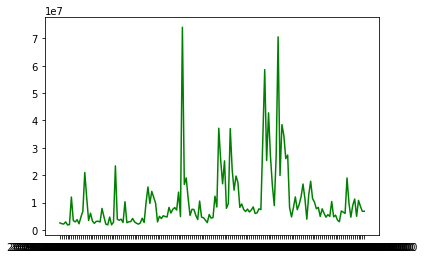

In [ ]:
plt.plot(data['volumeto'][40:200],'g')

In [7]:
data.columns[1:7]

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close'], dtype='object')

In [8]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[1:7]].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [9]:
values.min(axis=0)

array([4.6234502e+03, 3.9489199e+03, 4.2406899e+03, 1.6186000e+02,
       1.1648342e+06, 4.2406899e+03], dtype=float32)

In [10]:
np.max(values)

7859574300.0

In [11]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],values[train_size+val_size:,:]
print(len(train),len(val), len(test),len(test1))

8004 1000 1001 1001


In [12]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

7980
976
977
977


In [14]:
print(trainX.shape)
print(trainY.shape)

(7980, 24, 6)
(7980,)


In [15]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

### bidirectional LSTM

In [ ]:
first_input = Input(shape=(trainX.shape[1],trainX.shape[2]))

in1=Bidirectional(LSTM(90))(first_input)
in1=Dense(100)(in1)
in1=Dense(1)(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/최효정논문/bitcoin_bilstm_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 180)               69840     
_________________________________________________________________
dense_53 (Dense)             (None, 100)               18100     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 101       
Total params: 88,041
Trainable params: 88,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Epoch 1/200
249/250 [============================>.] - ETA: 0s - loss: 3.0589e-04

ValueError: ignored

In [ ]:
model.load_weights("saved_weights/bitcoin_bilstm.hdf5")

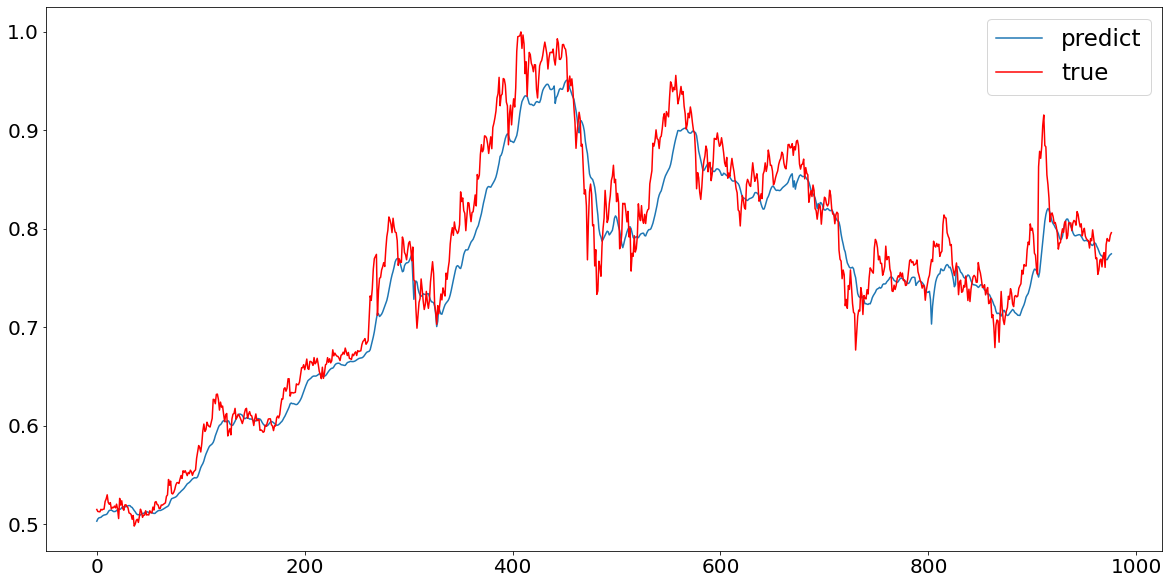

Test RMSE: 0.03050
Test MAE: 0.02252
Test MSE: 0.00093
Test MAPE: 0.02828
Test RMSE: 239716014.50992
Test MAE: 177012816.00000
Test MAPE: 0.02828


In [ ]:

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

### LSTM-CNN

In [22]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in0=add([first_input,in0])
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=add([in0,in1])

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2)(in1)#ad=Dropout(0.5)(ad)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmrescnn_24.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 24, 64)       18176       input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 24, 64)       12352       lstm_2[0][0]                     
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 24, 64)       8256        conv1d_12[0][0]                  
____________________________________________________________________________________________

In [24]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
80/80 [==============================] - 3s 14ms/step - loss: 0.0031 - val_loss: 1.3556e-04

Epoch 00001: val_loss improved from inf to 0.00014, saving model to saved_weights/btc_lstmrescnn_24.hdf5
Epoch 2/200
15/80 [====>.........................] - ETA: 0s - loss: 2.7492e-05

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


80/80 [==============================] - 1s 8ms/step - loss: 2.5167e-05 - val_loss: 1.2834e-04

Epoch 00002: val_loss improved from 0.00014 to 0.00013, saving model to saved_weights/btc_lstmrescnn_24.hdf5
Epoch 3/200
80/80 [==============================] - 1s 8ms/step - loss: 2.1607e-05 - val_loss: 1.0416e-04

Epoch 00003: val_loss improved from 0.00013 to 0.00010, saving model to saved_weights/btc_lstmrescnn_24.hdf5
Epoch 4/200
80/80 [==============================] - 1s 8ms/step - loss: 1.6609e-05 - val_loss: 1.0192e-04

Epoch 00004: val_loss improved from 0.00010 to 0.00010, saving model to saved_weights/btc_lstmrescnn_24.hdf5
Epoch 5/200
80/80 [==============================] - 1s 7ms/step - loss: 1.6296e-05 - val_loss: 1.0468e-04

Epoch 00005: val_loss did not improve from 0.00010
Epoch 6/200
80/80 [==============================] - 1s 8ms/step - loss: 1.5014e-05 - val_loss: 9.0365e-05

Epoch 00006: val_loss improved from 0.00010 to 0.00009, saving model to saved_weights/btc_lstm

In [ ]:
#model.load_weights("saved_weights/btc_lstmcnn_24.hdf5")

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

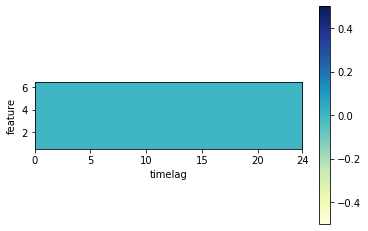

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 6]
y_label_list = [2,4,6]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 6], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [ ]:
model.load_weights("saved_weights/btc_lstmrescnn_24.hdf5")

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

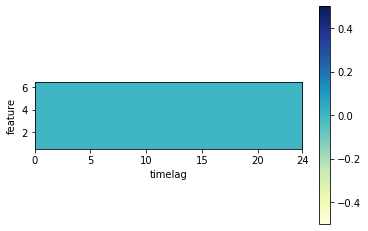

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 6]
y_label_list = [2,4,6]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 6], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

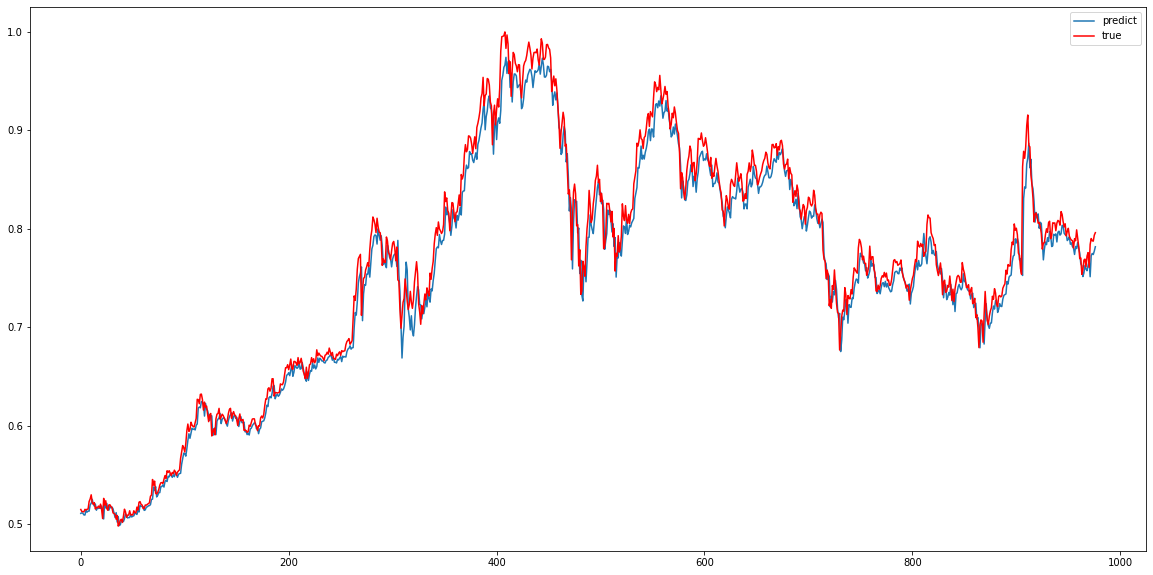

Test RMSE: 0.01637
Test MAE: 0.01244
Test MSE: 0.00027
Test MAPE: 0.18967
Test RMSE: 128679902.62286
Test MAE: 97781632.00000
Test MAPE: 0.18967


In [27]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

In [ ]:
model.load_weights("saved_weights/btc_lstmrescnn_24.hdf5")

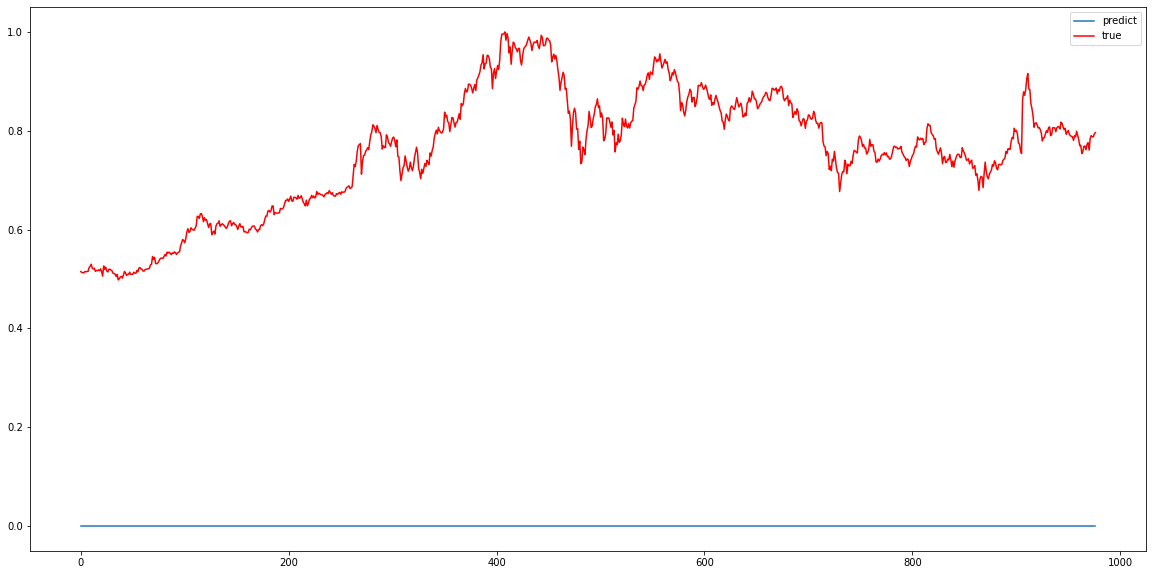

Test RMSE: 0.76964
Test MAE: 0.75977
Test MSE: 0.59234
Test MAPE: 100.00000
Test RMSE: 6049015100.74848
Test MAE: 5971499520.00000
Test MAPE: 100.00000


In [ ]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

In [ ]:
np.max(data.close)

41490.84

In [ ]:

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


In [ ]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

In [ ]:
test1X.shape

(977, 24, 6)

In [ ]:
id_=24*3

testX_inverse=test1X[id_][:,5]
testX_inverse

array([23215., 23232., 23218., 23377., 23311., 23293., 23516., 23405.,
       23702., 23724., 23617., 23594., 23459., 23465., 23595., 23590.,
       23621., 23649., 23677., 23924., 23975., 24560., 24344., 24499.],
      dtype=float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]


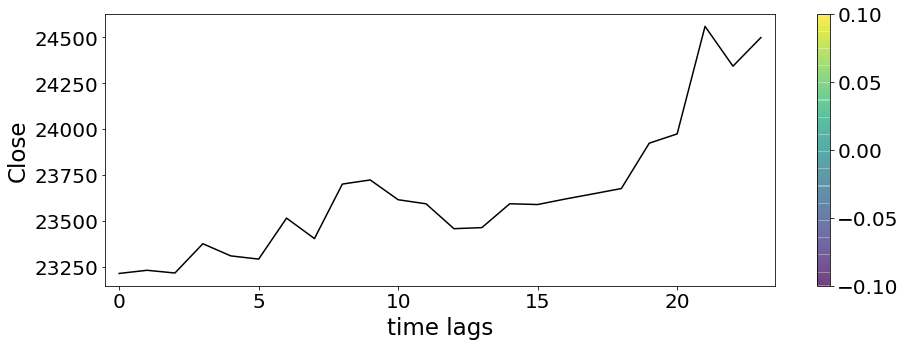

In [ ]:

from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

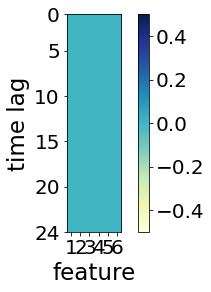

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 12]
x_label_list = [1,2,3,4,5,6]
y_label_list = [0,5,10,15,20,24]
ax.set_yticks([24,20,15,10,5,0])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6,0,24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

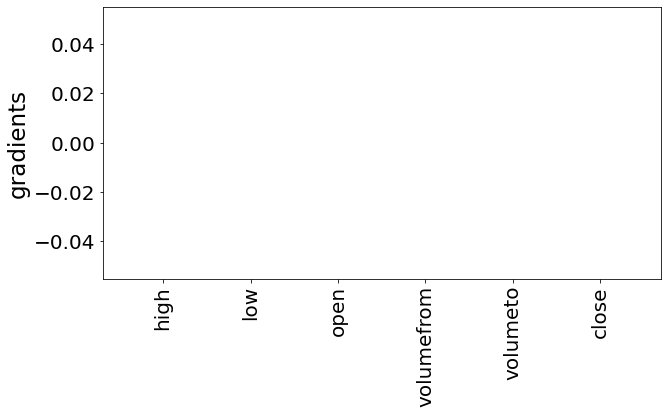

In [ ]:
columns=data.columns[1:7]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]


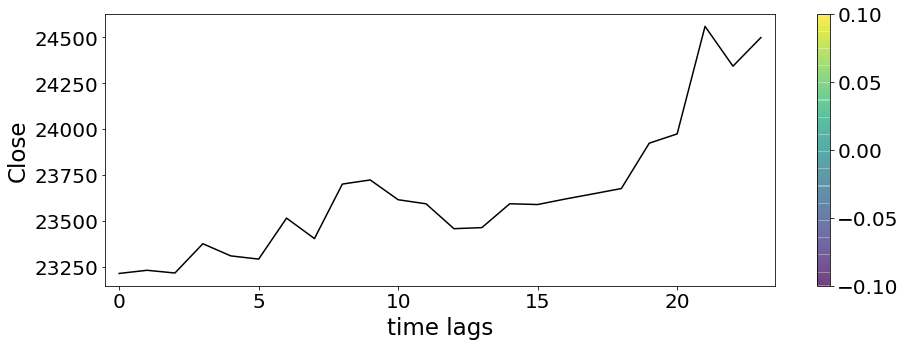

In [ ]:

from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

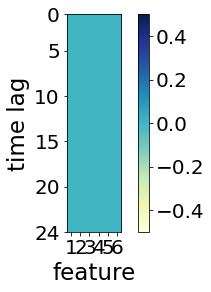

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 12]
x_label_list = [1,2,3,4,5,6]
y_label_list = [0,5,10,15,20,24]
ax.set_yticks([24,20,15,10,5,0])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6,0,24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

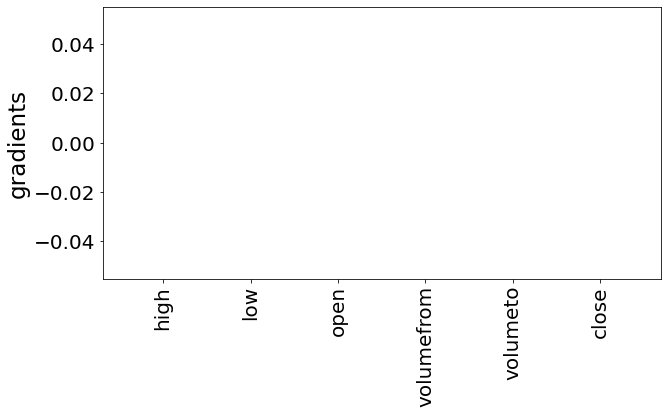

In [ ]:
columns=data.columns[1:7]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

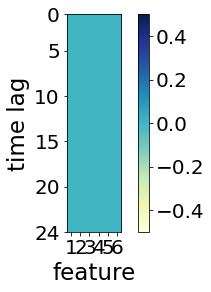

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 12]
x_label_list = [1,2,3,4,5,6]
y_label_list = [0,5,10,15,20,24]
ax.set_yticks([24,20,15,10,5,0])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6,0,24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [ ]:
model.load_weights('saved_weights/btc_reslstmcnn_24.hdf5')

OSError: ignored

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

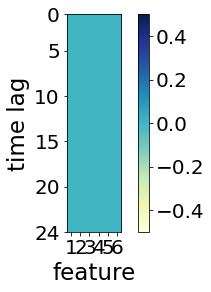

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 12]
x_label_list = [1,2,3,4,5,6]
y_label_list = [24,20,15,10,5,0]
ax.set_yticks([0,5,10,15,20,24])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6,0,24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

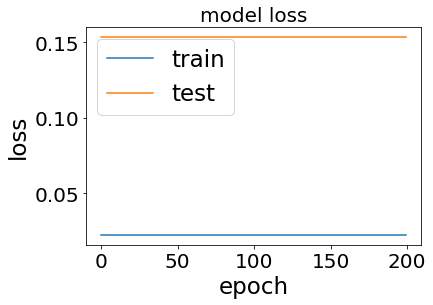

In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 0.01277, 0.01254, 

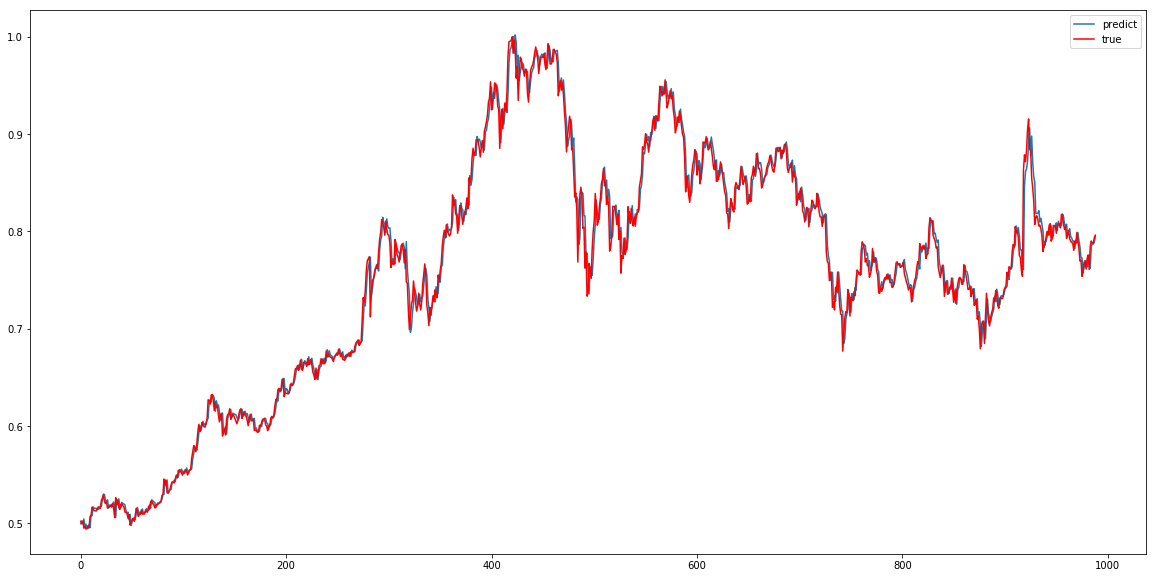

Test RMSE: 0.01254
Test MAE: 0.00860
Test MSE: 0.00016
Test RMSE: 476.80912
Test MAE: 327.09726


In [ ]:

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

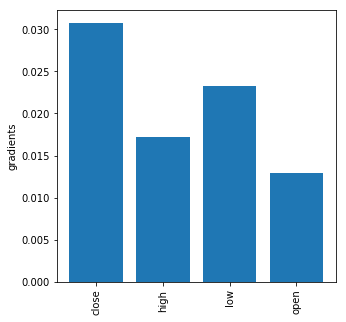

In [ ]:
columns='close','high','low','open'

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

## Res lstm-cnn

In [ ]:
first_input = Input(shape=(12,6))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3,activation='relu',padding='same')(in0) #main
#in1= BatchNormalization(scale=False)(in0)
#a=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0) #skip

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

ad=add([in0,in1],name='extractor')
ad=MaxPooling1D(pool_size=2)(ad)#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3,activation='relu',padding='same')(ad)
#in1= BatchNormalization(scale=False)(in0)
#b=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad) #skip
#ad=add([ad,ad1],name='extractor1')
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1 ,activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

ad1=add([in0,in1],name='extractor2')
ad1=MaxPooling1D(pool_size=2)(ad1)#ad=Dropout(0.5)(ad)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(ad1)
in1=Flatten()(ad1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')


model.summary()


checkpoint_path = "saved_weights/btc_reslstmcnn_onestep_relu.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 12, 6)]      0                                            
__________________________________________________________________________________________________
lstm_34 (LSTM)                  (None, 12, 64)       18176       input_45[0][0]                   
__________________________________________________________________________________________________
conv1d_242 (Conv1D)             (None, 12, 64)       12352       lstm_34[0][0]                    
__________________________________________________________________________________________________
conv1d_243 (Conv1D)             (None, 12, 64)       8256        conv1d_242[0][0]                 
___________________________________________________________________________________________

In [ ]:
history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400


ValueError: ignored

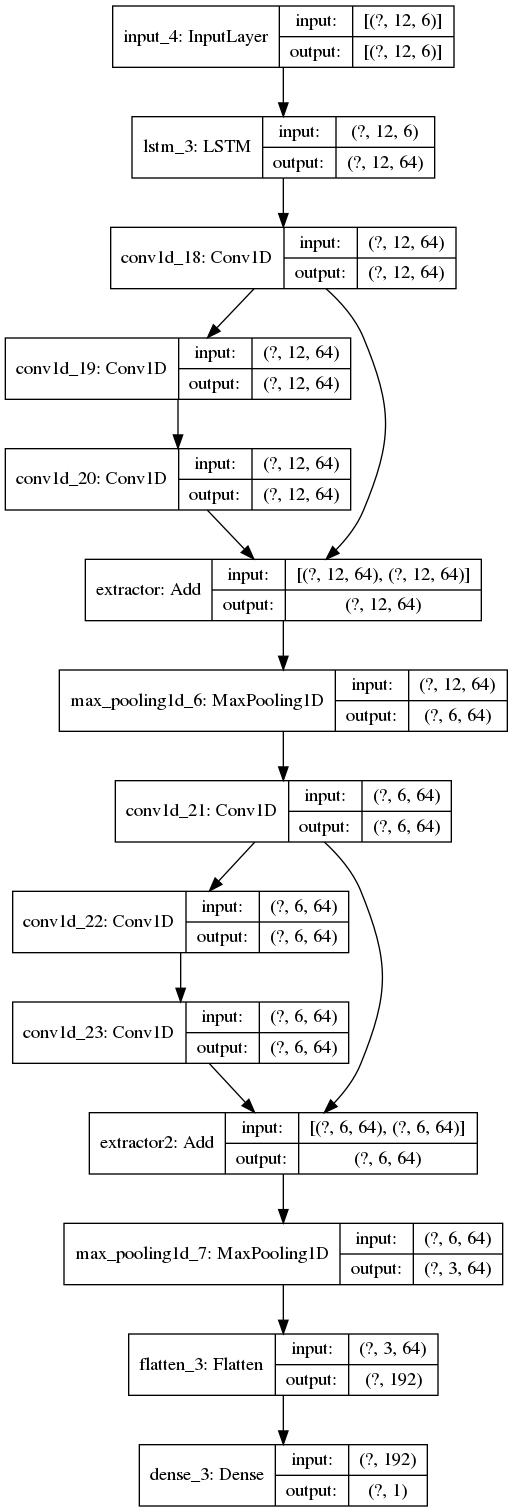

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
%matplotlib inline
dot_img_file = './model.png'

plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
model.load_weights("saved_weights/btc_reslstmcnn_onestep2_.hdf5")

ValueError: Shapes (192, 1) and (768, 1) are incompatible

In [ ]:
model.load_weights("saved_weights/btc_reslstmcnn_onestep_relu.hdf5")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 6]
y_label_list = [2,4,6]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 6], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,384], In[1]: [192,1] [Op:MatMul]

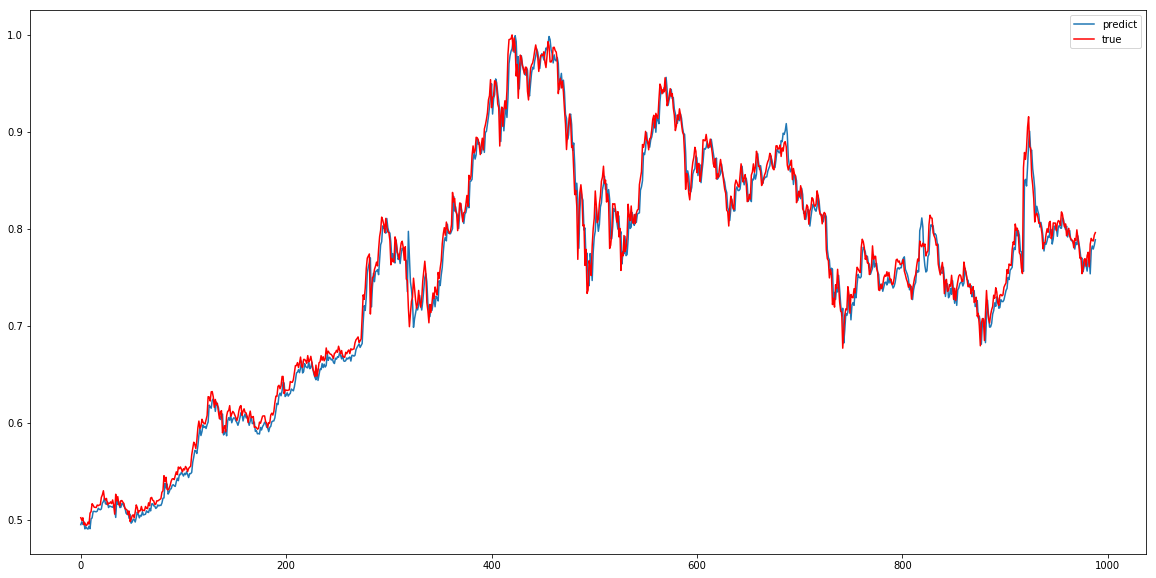

Test RMSE: 0.01381
Test MAE: 0.01007
Test MSE: 0.00019
Test RMSE: 514.58287
Test MAE: 375.20963


In [ ]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

testY=testY.reshape(-1,1)
yhat_inverse = yhat*(values.max(axis=0)-values.min(axis=0))+values.min(axis=0)
testY_inverse=testY*(values.max(axis=0)-values.min(axis=0))+values.min(axis=0)
yhat_inverse=yhat_inverse[:,-1]
testY_inverse=testY_inverse[:,-1]

rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

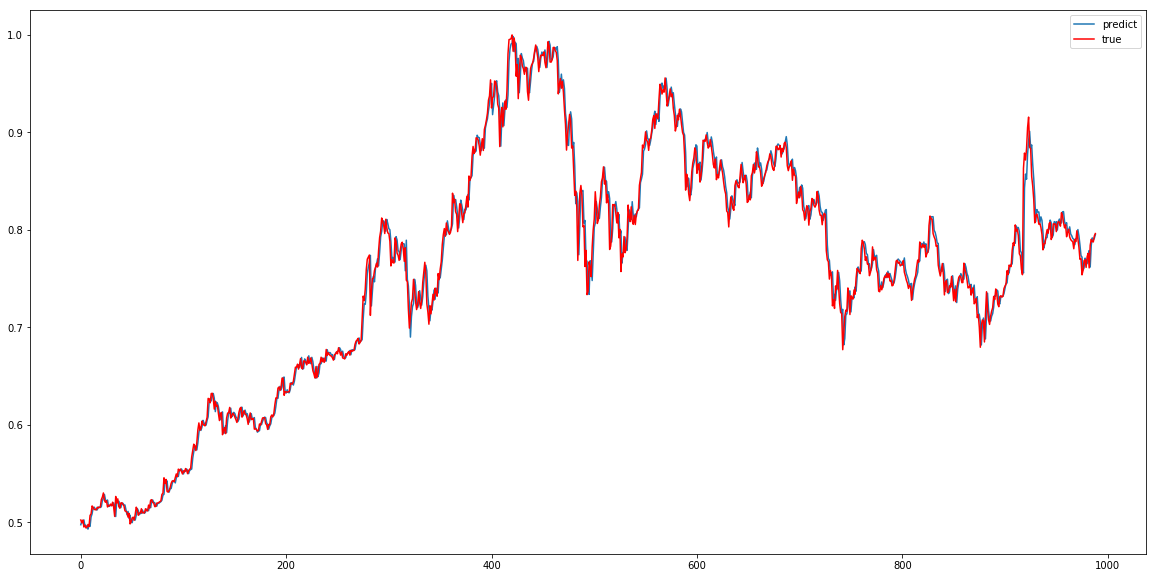

Test RMSE: 0.01228
Test MAE: 0.00848
Test MSE: 0.00015
Test RMSE: 466.82470
Test MAE: 322.26086


In [ ]:
#model.load_weights("saved_weights/btc_reslstmcnn_onestep1.hdf5")
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

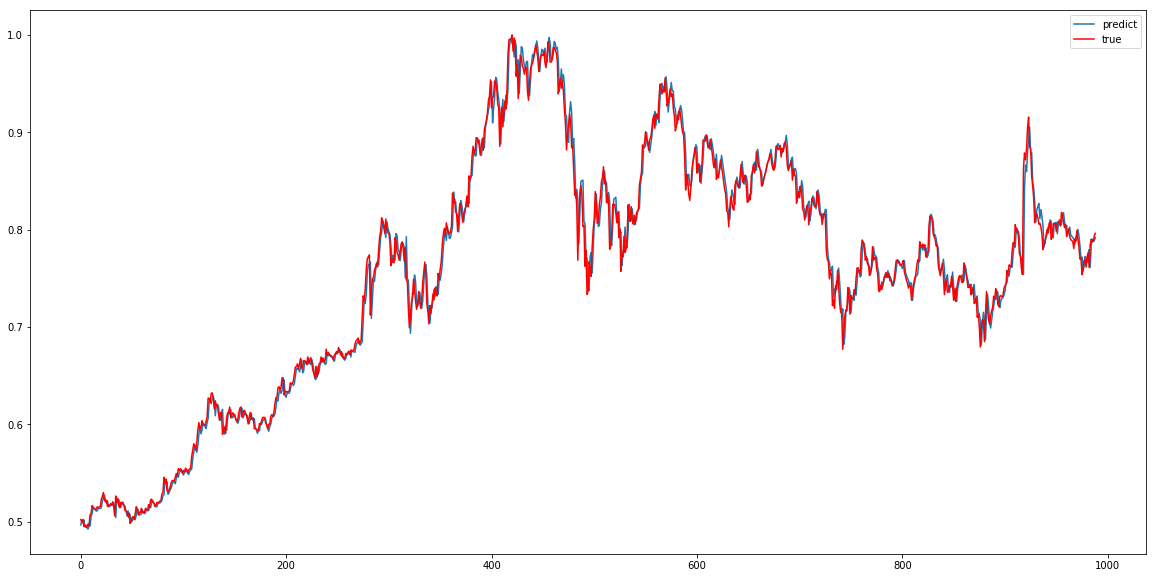

Test RMSE: 0.01249
Test MAE: 0.00866
Test MSE: 0.00016
Test RMSE: 474.64725
Test MAE: 329.23111


In [ ]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

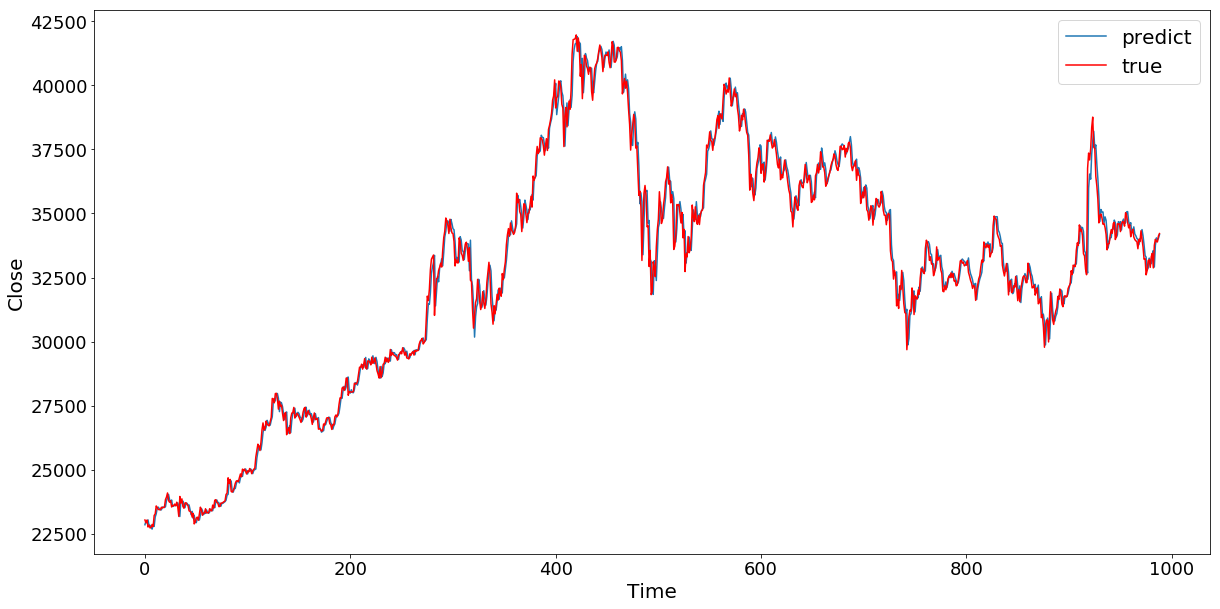

In [ ]:
plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

#
#plt.ylim(23000,27000)
plt.xlabel('Time')

plt.ylabel('Close')

pyplot.show()

### 1D-CNN

In [ ]:

first_input = Input(shape=(24,6))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(40, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/btc_1dcnn1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model

# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 24, 64)            1216      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 24, 64)            4160

In [ ]:
history=model.fit(trainX, trainY, epochs=400, batch_size=200, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
40/40 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 3.7893e-04

Epoch 00001: val_loss improved from inf to 0.00038, saving model to saved_weights/btc_1dcnn1.hdf5
Epoch 2/400
40/40 [==============================] - 0s 6ms/step - loss: 2.4914e-05 - val_loss: 1.0925e-04

Epoch 00002: val_loss improved from 0.00038 to 0.00011, saving model to saved_weights/btc_1dcnn1.hdf5
Epoch 3/400
40/40 [==============================] - 0s 6ms/step - loss: 1.6985e-05 - val_loss: 1.0862e-04

Epoch 00003: val_loss improved from 0.00011 to 0.00011, saving model to saved_weights/btc_1dcnn1.hdf5
Epoch 4/400
40/40 [==============================] - 0s 6ms/step - loss: 1.3470e-05 - val_loss: 1.0684e-04

Epoch 00004: val_loss improved from 0.00011 to 0.00011, saving model to saved_weights/btc_1dcnn1.hdf5
Epoch 5/400
40/40 [==============================] - 0s 6ms/step - loss: 1.1883e-05 - val_loss: 1.2579e-04

Epoch 00005: val_loss did not improve from 0.00011
Epoch 6/

In [ ]:
#model.load_weights("saved_weights/btc_1dcnn1.hdf5")

In [ ]:
def MAPE(y_true, y_pred):
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

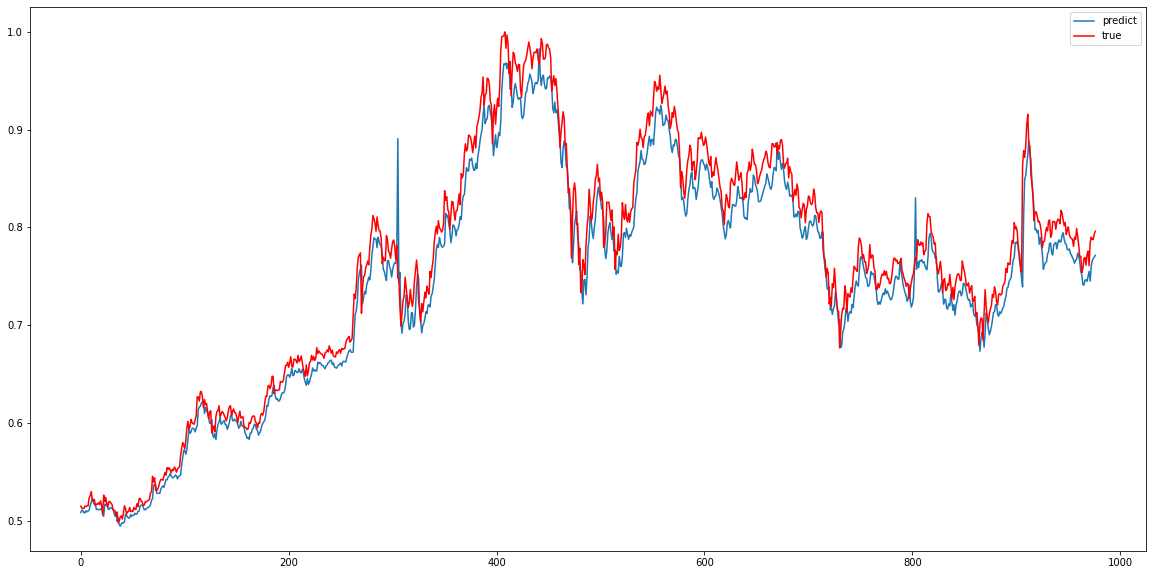

Test RMSE: 0.02298
Test MAE: 0.01897
Test MSE: 0.00053
Test MAPE: 18.79900
Test RMSE: 180633628.97850
Test MAE: 149073136.00000
Test MAPE: 18.79900


In [ ]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

In [ ]:
#0.01254, 0.01307

### CNN-LSTM

In [ ]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,6))

#in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=MaxPooling1D(pool_size=2)(in1)

#in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
in1=LSTM(units =64 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
#in1=Dense(100)(in1)
#in1=Dropout(0.5)(in1)
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [ ]:
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 24, 64)            1216      
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 24, 64)            8256      
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 24, 64)            4160      
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 24, 64)            12352     
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 24, 64)            8256      
_________________________________________________________________
extractor (Conv1D)           (None, 24, 64)            416

In [ ]:
history=model.fit(trainX, trainY, epochs=400, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/400
80/80 [==============================] - 4s 14ms/step - loss: 0.0010 - val_loss: 2.0821e-04

Epoch 00001: val_loss improved from inf to 0.00021, saving model to saved_weights/btc_cnnlstm.hdf5
Epoch 2/400
80/80 [==============================] - 1s 8ms/step - loss: 1.3563e-05 - val_loss: 1.5967e-04

Epoch 00002: val_loss improved from 0.00021 to 0.00016, saving model to saved_weights/btc_cnnlstm.hdf5
Epoch 3/400
80/80 [==============================] - 1s 7ms/step - loss: 1.3090e-05 - val_loss: 2.4290e-04

Epoch 00003: val_loss did not improve from 0.00016
Epoch 4/400
80/80 [==============================] - 1s 8ms/step - loss: 1.1716e-05 - val_loss: 1.7343e-04

Epoch 00004: val_loss did not improve from 0.00016
Epoch 5/400
80/80 [==============================] - 1s 8ms/step - loss: 1.1949e-05 - val_loss: 1.1929e-04

Epoch 00005: val_loss improved from 0.00016 to 0.00012, saving model to saved_weights/btc_cnnlstm.hdf5
Epoch 6/400
80/80 [==============================] - 1s 

In [ ]:
#model.load_weights("saved_weights/btc_cnnlstm.hdf5")

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

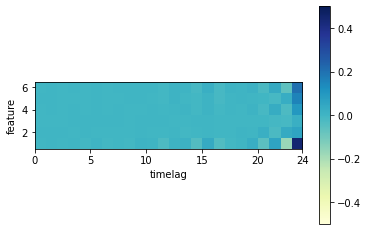

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 6]
y_label_list = [2,4,6]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 6], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

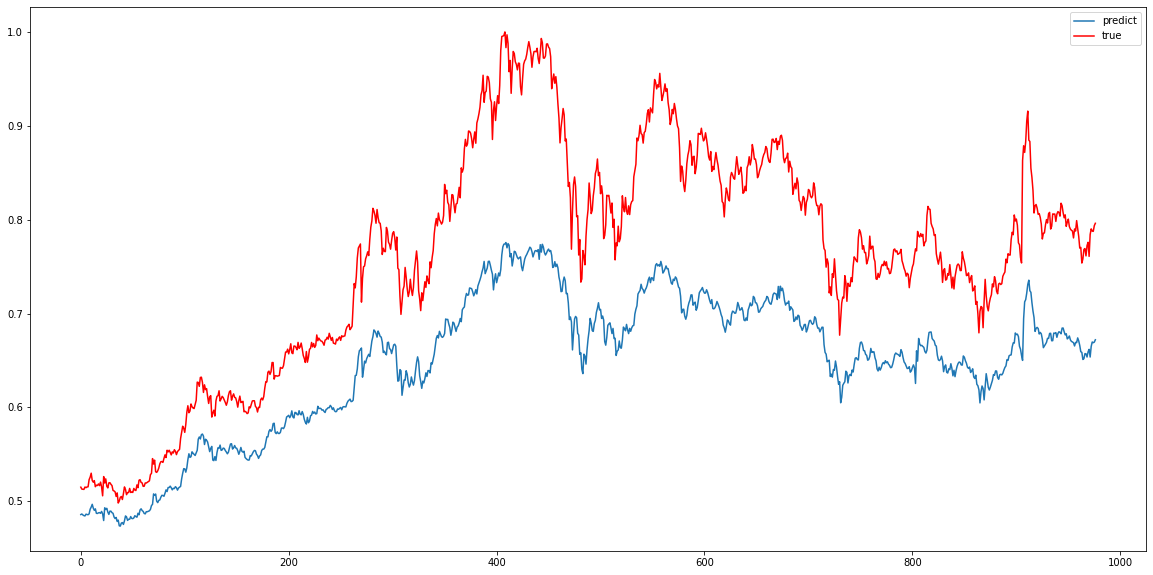

Test RMSE: 0.12286
Test MAE: 0.11265
Test MSE: 0.01509
Test MAPE: 19.41438
Test RMSE: 965622680.32579
Test MAE: 885386368.00000
Test MAPE: 19.41438


In [ ]:
## 1dcnn(5,3,1)-lstm

from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

In [ ]:
id_=24*3

testX_inverse=test1X[id_][:,5]
testX_inverse

array([23215., 23232., 23218., 23377., 23311., 23293., 23516., 23405.,
       23702., 23724., 23617., 23594., 23459., 23465., 23595., 23590.,
       23621., 23649., 23677., 23924., 23975., 24560., 24344., 24499.],
      dtype=float32)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


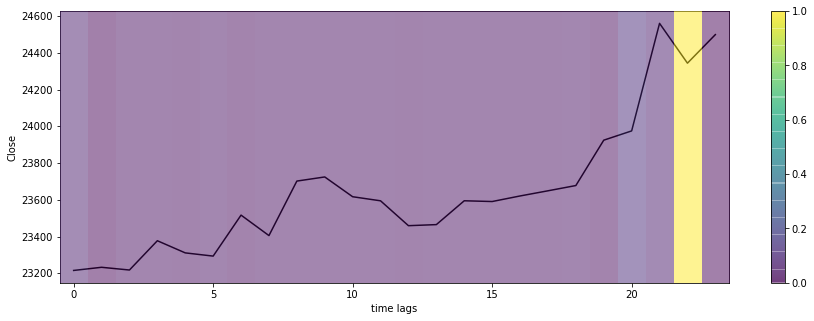

In [ ]:

from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')

plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

(1, 24, 6)


<Figure size 1080x5040 with 0 Axes>

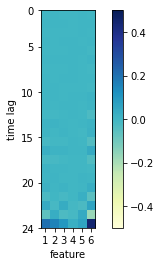

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,6)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 6, 0 , 12]
x_label_list = [1,2,3,4,5,6]
y_label_list = [0,5,10,15,20,24]
ax.set_yticks([24,20,15,10,5,0])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 6,0,24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

### Timedistributed LSTM-CNN

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

In [ ]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,12,4))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

in0=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in0)

#in1=add([in0,in1])
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)

#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =150 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_timelstmcnn15051.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 12, 4)]     0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 12, 150)     93000     
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 8, 64)       48064     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 8, 64)       4160      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 256)         0         
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           257 

In [ ]:
## timedistribute lstm(100)-1dcnn

history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/500


ValueError: ignored

In [ ]:
model.load_weights("saved_weights/btc_timelstmcnn15051.hdf5")

In [ ]:

## timedistributed lstm150-1dcnn(5,1)

from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
pyplot.show()

rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

ValueError: ignored

### visualize

In [ ]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

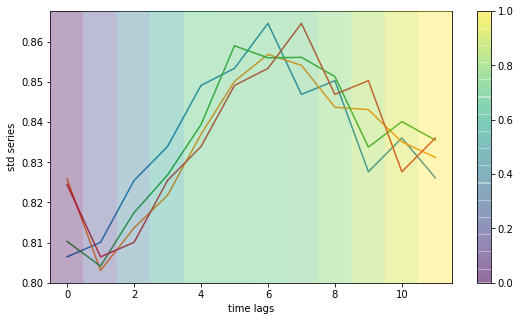

In [ ]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

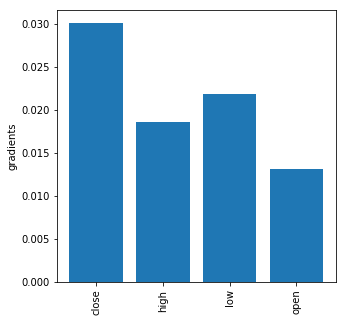

In [ ]:
columns='close','high','low','open'

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)